In [ ]:
# Dogs vs Cats Classification using Two Models (Simple CNN and MobileNetV2 (Transfer Learning))

In [ ]:
#Importing the libraries


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Loads images,Resize's them,normalise pixels
import os, pathlib   # Navigate Downloaded folders

print("TensorFlow_Version : ", tf.__version__)



TensorFlow_Version :  2.19.0


In [ ]:
# Downloading the Cats & Dogs Dataset

import tensorflow_datasets as tfds

dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
train_ds = dataset['train']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.AB6VLC_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
# Only use a subset for faster training

LIMIT_TRAIN = 4000     # Number of training samples
LIMIT_VAL = 1000       # Number of validation samples

train_data_raw = train_ds.take(LIMIT_TRAIN)
val_data_raw = train_ds.skip(LIMIT_TRAIN).take(LIMIT_VAL)


In [ ]:
# PreProcessing (Resize + Normalize)

IMG_SIZE = 160

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

train_data = train_data_raw.map(preprocess).batch(32).prefetch(1)  # MAP apply a function to every item in the dataset
val_data = val_data_raw.map(preprocess).batch(32).prefetch(1)


In [ ]:
#Building Model 1 – Simple CNN

model_1 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# configure  the model for training

model_1.compile(
    optimizer="Adam",
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,401,921 (20.61 MB)

 Trainable params: 5,401,921 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_1 = model_1.fit(
    train_data,
    epochs=5,
    validation_data=val_data
)


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.5370 - loss: 0.7255 - val_accuracy: 0.6110 - val_loss: 0.6634
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.6099 - loss: 0.6642 - val_accuracy: 0.6750 - val_loss: 0.6071
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.6950 - loss: 0.5872 - val_accuracy: 0.7160 - val_loss: 0.5700
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7521 - loss: 0.5118 - val_accuracy: 0.7330 - val_loss: 0.5505
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8034 - loss: 0.4288 - val_accuracy: 0.6970 - val_loss: 0.6612


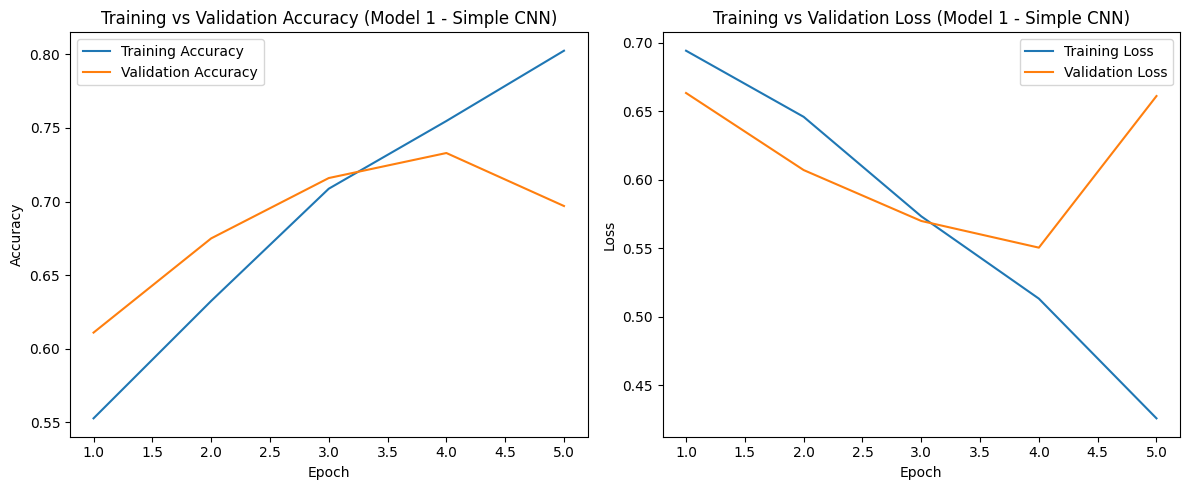

In [ ]:
# Visualize Training – Accuracy & Loss Curves

import matplotlib.pyplot as plt

# 1. Extract values from history object
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(acc) + 1)

# 2. Create figure
plt.figure(figsize=(12, 5))

# 3. Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Model 1 - Simple CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 4. Loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss (Model 1 - Simple CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#Evaluate CNN on Validation Data

val_loss, val_acc = model_1.evaluate(val_data)
print("Final Validation Loss (Model 1):", val_loss)
print("Final Validation Accuracy (Model 1):", val_acc)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6771 - loss: 0.6730
Final Validation Loss (Model 1): 0.6611801981925964
Final Validation Accuracy (Model 1): 0.6970000267028809


In [ ]:
# MODEL 2 - MobileNetV2

IMG_SIZE = 160

def preprocess_mnet(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

train_data_m2 = train_data_raw.map(preprocess_mnet).batch(32).prefetch(1)
val_data_m2   = val_data_raw.map(preprocess_mnet).batch(32).prefetch(1)


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # freeze base model weights

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
#Train (Transfer Learning)

history_2 = model_2.fit(
    train_data_m2,
    epochs=5,
    validation_data=val_data_m2
)


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accuracy: 0.9378 - loss: 0.1479 - val_accuracy: 0.9760 - val_loss: 0.0796
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9891 - loss: 0.0329 - val_accuracy: 0.9690 - val_loss: 0.1244
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9946 - loss: 0.0169 - val_accuracy: 0.9730 - val_loss: 0.1128
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.9958 - loss: 0.0135 - val_accuracy: 0.9720 - val_loss: 0.1263
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9967 - loss: 0.0090 - val_accuracy: 0.9700 - val_loss: 0.1250


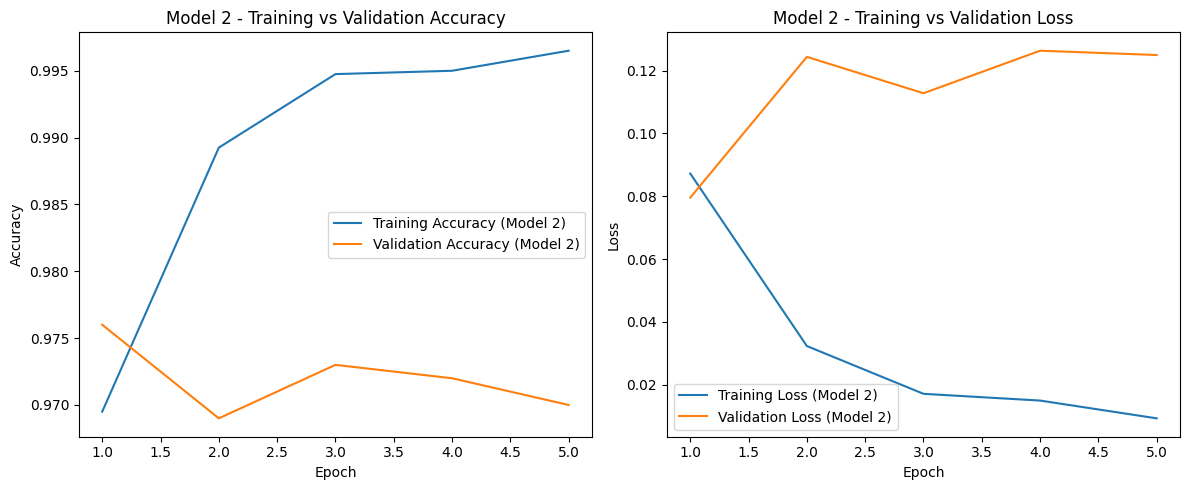

In [ ]:
# Plotting Accuracy & Loss

import matplotlib.pyplot as plt

acc2 = history_2.history['accuracy']
val_acc2 = history_2.history['val_accuracy']
loss2 = history_2.history['loss']
val_loss2 = history_2.history['val_loss']

epochs2 = range(1, len(acc2) + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs2, acc2, label='Training Accuracy (Model 2)')
plt.plot(epochs2, val_acc2, label='Validation Accuracy (Model 2)')
plt.title('Model 2 - Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs2, loss2, label='Training Loss (Model 2)')
plt.plot(epochs2, val_loss2, label='Validation Loss (Model 2)')
plt.title('Model 2 - Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#Evaluate on Validation Data
val_loss_2, val_acc_2 = model_2.evaluate(val_data_m2)
print("Final Validation Loss (Model 2):", val_loss_2)
print("Final Validation Accuracy (Model 2):", val_acc_2)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9656 - loss: 0.1295
Final Validation Loss (Model 2): 0.12495625764131546
Final Validation Accuracy (Model 2): 0.9700000286102295


In [ ]:
#Comparing Model 1 vs Model 2

m1_train_last = history_1.history['accuracy'][-1]
m1_val_last   = history_1.history['val_accuracy'][-1]

m2_train_last = history_2.history['accuracy'][-1]
m2_val_last   = history_2.history['val_accuracy'][-1]

print("Model 1 - Train:", m1_train_last, " Val:", m1_val_last)
print("Model 2 - Train:", m2_train_last, " Val:", m2_val_last)


Model 1 - Train: 0.8025000095367432  Val: 0.6970000267028809
Model 2 - Train: 0.9965000152587891  Val: 0.9700000286102295


Saving cat.jpg to cat.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Prediction: Cat (1.00)


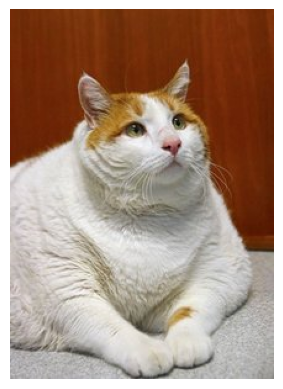

In [ ]:
#Real Image Prediction (Dog vs Cat)

from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

uploaded = files.upload()

for file_name in uploaded.keys():
    # Load and display the image
    image = Image.open(file_name)
    plt.imshow(image)
    plt.axis('off')

    # Preprocess image
    image = image.resize((160, 160))
    img_array = np.array(image)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # make it batch of 1

    # Predict
    prediction = model_2.predict(img_array)[0][0]

    if prediction > 0.5:
        print(f"Prediction: Dog ({prediction:.2f})")
    else:
        print(f"Prediction: Cat ({1 - prediction:.2f})")
